# Recognize named entities on Twitter with LSTMs

In this assignment, you will use a recurrent neural network to solve Named Entity Recognition (NER) problem. NER is a common task in natural language processing systems. It serves for extraction such entities from the text as persons, organizations, locations, etc. In this task you will experiment to recognize named entities from Twitter.

For example, we want to extract persons' and organizations' names from the text. Than for the input text:

    Ian Goodfellow works for Google Brain

a NER model needs to provide the following sequence of tags:

    B-PER I-PER    O     O   B-ORG  I-ORG

Where *B-* and *I-* prefixes stand for the beginning and inside of the entity, while *O* stands for out of tag or no tag. Markup with the prefix scheme is called *BIO markup*. This markup is introduced for distinguishing of consequent entities with similar types.

A solution of the task will be based on neural networks, particularly, on Bi-Directional Long Short-Term Memory Networks (Bi-LSTMs).

### Libraries

For this task you will need the following libraries:
 - [pytorch](https://pytorch.org/) — an open-source software library for Machine Intelligence.
    
 - [Numpy](http://www.numpy.org) — a package for scientific computing.
 

# 1. Data


### 1.1. Get Resources
The following cell will download all data required for this assignment into the folder `./data`.

In [ ]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False

if IN_COLAB:
    ! wget https://raw.githubusercontent.com/hse-aml/natural-language-processing/master/setup_google_colab.py -O setup_google_colab.py
    import setup_google_colab
    setup_google_colab.setup_week2()

import sys
sys.path.append("..")
from common.download_utils import download_week2_resources

download_week2_resources()

### 1.2. Load the Twitter Named Entity Recognition corpus

We will work with a corpus, which contains tweets with NE tags. Every line of a file contains a pair of a token (word/punctuation symbol) and a tag, separated by a whitespace. Different tweets are separated by an empty line.

The function *read_data* reads a corpus from the *file_path* and returns two lists: one with tokens and one with the corresponding tags. You need to complete this function by adding a code, which will replace a user's nickname to `<USR>` token and any URL to `<URL>` token. You could think that a URL and a nickname are just strings which start with *http://* or *https://* in case of URLs and a *@* symbol for nicknames.

In [3]:
def read_data(file_path):
    tokens = []
    tags = []
    
    tweet_tokens = []
    tweet_tags = []
    for line in open(file_path, encoding='utf-8'):
        line = line.strip()
        if not line:
            if tweet_tokens:
                tokens.append(tweet_tokens)
                tags.append(tweet_tags)
            tweet_tokens = []
            tweet_tags = []
        else:
            token, tag = line.split()
            # Replace all urls with <URL> token
            # Replace all users with <USR> token

            if token.lower().startswith("http://") or token.lower().startswith("https://"):
              token = "<URL>"
            if token.startswith("@"):
              token = "<USR>"
                
            tweet_tokens.append(token)
            tweet_tags.append(tag)
            
    return tokens, tags

And now we can load three separate parts of the dataset:
 - *train* data for training the model;
 - *validation* data for evaluation and hyperparameters tuning;
 - *test* data for final evaluation of the model.

In [4]:
train_tokens, train_tags = read_data('data/train.txt')
validation_tokens, validation_tags = read_data('data/validation.txt')
test_tokens, test_tags = read_data('data/test.txt')

You should always understand what kind of data you deal with. For this purpose, you can print the data running the following cell:

In [4]:
print("Number of training samples: \t\t", len(train_tokens))
print("Number of validation samples: \t\t", len(validation_tokens))
print("Number of test samples: \t\t", len(test_tokens))

Number of training samples: 		 5795
Number of validation samples: 		 724
Number of test samples: 		 724


In [ ]:
for i in range(2):
    for token, tag in zip(train_tokens[i], train_tags[i]):
        print('%s\t%s' % (token, tag))
    print()

### 1.3. Prepare dictionaries

To train a neural network, we will use two mappings: 
- {token}$\to${token id}: address the row in embeddings matrix for the current token;
- {tag}$\to${tag id}: one-hot ground truth probability distribution vectors for computing the loss at the output of the network.

Now you need to implement the function *build_dict* which will return {token or tag}$\to${index} and vice versa. 

In [5]:
from collections import defaultdict
import numpy as np

In [21]:
def build_dict(tokens_or_tags, special_tokens):
    """
        tokens_or_tags: a list of lists of tokens or tags
        special_tokens: some special tokens
    """
    # Create a dictionary with default value 0
    # The lambda function gets called whenever it needs a default value.
    tok2idx = defaultdict(lambda: 0)
    idx2tok = []
    
    # Create mappings from tokens (or tags) to indices and vice versa.
    # At first, add special tokens (or tags) to the dictionaries.
    # The first special token must have index 0.
    idx = 0
    for token in special_tokens:
      tok2idx.update({token: idx})
      idx2tok.append(token)
      idx += 1
    
    # Mapping tok2idx should contain each token or tag only once. 
    # To do so, you should:
    # 1. extract unique tokens/tags from the tokens_or_tags variable, which is not
    #    occur in special_tokens (because they could have non-empty intersection)
    # 2. index them (for example, you can add them into the list idx2tok
    # 3. for each token/tag save the index into tok2idx).
    
    for token_list in tokens_or_tags:
      for token in token_list:
        if token not in tok2idx:
          tok2idx.update({token: idx})
          idx2tok.append(token)
          idx += 1
    return tok2idx, idx2tok

After implementing the function *build_dict* you can make dictionaries for tokens and tags. Special tokens in our case will be:
 - `<UNK>` token for out of vocabulary tokens;
 - `<PAD>` token for padding sentence to the same length when we create batches of sentences.

In [22]:
special_tokens = ['<UNK>', '<PAD>']
special_tags = ['O']

# Create dictionaries 
token2idx, idx2token = build_dict(train_tokens + validation_tokens, special_tokens)
tag2idx, idx2tag = build_dict(train_tags, special_tags)

### 1.4. Generate batches

Neural Networks are usually trained with batches. It means that weight updates of the network are based on several sequences at every single time. The tricky part is that all sequences within a batch need to have the same length. So we will pad them with a special `<PAD>` token. It is also a good practice to provide RNN with sequence lengths, so it can skip computations for padding parts. We provide the batching function *batches_generator* readily available for you to save time. 

In [23]:
def batches_generator(batch_size, tokens, tags,
                      shuffle=True, allow_smaller_last_batch=True):
    """Generates padded batches of tokens and tags."""
    n_samples = len(tokens)
    if shuffle:
        order = np.random.permutation(n_samples)
    else:
        order = np.arange(n_samples)

    n_batches = n_samples // batch_size
    if allow_smaller_last_batch and n_samples % batch_size:
        n_batches += 1

    for k in range(n_batches):
        batch_start = k * batch_size
        batch_end = min((k + 1) * batch_size, n_samples)
        current_batch_size = batch_end - batch_start
        x_list = []
        y_list = []
        max_len_token = 0
        for idx in order[batch_start: batch_end]:
            x_list.append(words2idxs(tokens[idx]))
            y_list.append(tags2idxs(tags[idx]))
            max_len_token = max(max_len_token, len(tags[idx]))
            
        # Fill in the data into numpy nd-arrays filled with padding indices.
        x = np.ones([current_batch_size, max_len_token], dtype=np.int32) * token2idx['<PAD>']
        y = np.ones([current_batch_size, max_len_token], dtype=np.int32) * tag2idx['O']
        lengths = np.zeros(current_batch_size, dtype=np.int32)
        for n in range(current_batch_size):
            utt_len = len(x_list[n])

            x[n, :utt_len] = x_list[n]
            lengths[n] = utt_len
            y[n, :utt_len] = y_list[n]
        yield x, y, lengths

### 1.5. Dictionary Mappings

The next additional functions will help you to create the mapping between tokens and ids for a sentence. 

In [9]:
def words2idxs(tokens_list):
    return [token2idx[word] for word in tokens_list]

def tags2idxs(tags_list):
    return [tag2idx[tag] for tag in tags_list]

def idxs2words(idxs):
    return [idx2token[idx] for idx in idxs]

def idxs2tags(idxs):
    return [idx2tag[idx] for idx in idxs]

#2. Model

### 2.1. Hyper-Parameters

In [11]:
import torch
from torch.nn import LSTM
from torch import nn
from torch import optim
import torch.nn.functional as F
import matplotlib.pyplot as plt 
import time
import math

# specify GPU
device = torch.device("cuda")

In [41]:
# Model design
EMBEDDING_DIM = 200
HIDDEN_DIM = 128
DROPOUT = 0.5
NUM_LAYERS = 2
BIDIRECTIONAL = True

# Training phase
BATCH_SIZE = 32
EPOCHS = 20
LR = 0.01
LR_Decay = math.sqrt(2)

[This page](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) may help you understand the following code.

### 2.2. Design Network

This is the most important part of the assignment. Here we will specify the network architecture based on TensorFlow building blocks. It's fun and easy as a lego constructor! We will create an LSTM network which will produce probability distribution over tags for each token in a sentence. To take into account both right and left contexts of the token, we will use Bi-Directional LSTM (Bi-LSTM). Dense layer will be used on top to perform tag classification.  

In [42]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        super(LSTMTagger, self).__init__()
        self.hidden_dim = hidden_dim

        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)

        # The LSTM takes word embeddings as inputs, and outputs hidden states
        # with dimensionality hidden_dim.
        self.lstm = nn.LSTM(embedding_dim, 
                            hidden_dim, 
                            num_layers=NUM_LAYERS, 
                            dropout=DROPOUT,
                            bidirectional=BIDIRECTIONAL)

        # The linear layer that maps from hidden state space to tag space
        if BIDIRECTIONAL:
          self.hidden2tag = nn.Linear(hidden_dim*2, tagset_size)
        else:
          self.hidden2tag = nn.Linear(hidden_dim, tagset_size)

    def forward(self, sentence):
                                                    # sentence: [bs x T]
        embeds = self.word_embeddings(sentence)
                                                      # embeds: [bs x T x E] 
        embeds = embeds.permute(1, 0, 2)
        lstm_out, _ = self.lstm(embeds)
                                                          # in: [T x bs x E]
                                                         # out: [T x bs x D*n-dir]
        preds = self.hidden2tag(lstm_out)
                                                       # preds: [T x bs x N]
        tag_scores = F.log_softmax(preds, dim=2)
        return tag_scores.permute(1, 0, 2), preds.permute(1, 0, 2)

### 2.3. Loss and Optimizer

During training we do not need predictions of the network, but we need a loss function. We will use [cross-entropy loss](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html?highlight=crossentropy#torch.nn.CrossEntropyLoss), efficiently implemented in PyTorch. 

Note that it should be applied to the output of the model before softmax probabilities. Also note,  that we do not want to take into account loss terms coming from `<PAD>` tokens. So we need to mask them out, before computing the loss.


Moreover, please note that because the `O` class (not-entity words) is large. To mitigate the imbalance classes, we use weights in the loss function to rescale the loss for each class. 

In [30]:
from sklearn.utils.class_weight import compute_class_weight

#compute the class weights
flat_train_tags = [item for sublist in train_tags for item in sublist]
# class_wts = compute_class_weight('balanced', np.unique(flat_train_tags), flat_train_tags)
class_wts = compute_class_weight('balanced', idx2tag, flat_train_tags)
print(["{0:0.2f}".format(w) for w in class_wts])

weights = torch.tensor(class_wts, dtype=torch.float)

['0.05', '20.52', '24.05', '14.97', '8.22', '7.40', '5.37', '6.29', '5.94', '15.16', '11.70', '21.94', '4.78', '20.61', '21.74', '9.88', '70.02', '52.32', '82.09', '82.09', '68.02']


In [31]:
len(weights)

21

In [43]:
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, len(token2idx), len(tag2idx))

# push the model to GPU
model = model.to(device)

# loss_function = nn.CrossEntropyLoss(ignore_index=tag2idx["O"], weight=weights.to(device))
loss_function = nn.CrossEntropyLoss(ignore_index=tag2idx["O"])
optimizer = optim.SGD(model.parameters(), lr=LR)
# optimizer = optim.Adam(model.parameters(), lr=LR)

# Train

### 3.1. Train Function

[This page](https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html) may help you to understand the following cell.

In [44]:
# TEMP = 2

# function to train the model
def train():
  
  model.train()

  avg_loss = 0
  n = 0
  for x_batch, y_batch, lengths in batches_generator(BATCH_SIZE, train_tokens, train_tags):

      # Step 1. Remember that Pytorch accumulates gradients.
      # We need to clear them out before each instance
      model.zero_grad()

      # Step 2. Get our inputs ready for the network, that is, turn them into
      # Tensors of word indices.
      sentence_in = torch.LongTensor(x_batch)   # [bs x T]
      targets = torch.LongTensor(y_batch)        # [bs x T]

      # Step 3. Run our forward pass.
      _, preds = model(sentence_in.to(device))                         # [bs x T x N]

      # print("Train Target size: ", targets.shape)
      # print("Train preds size: ", preds.shape)

      # Step 4. Compute the loss, gradients, and update the parameters by
      #  calling optimizer.step()
      loss = loss_function(preds.permute(0, 2, 1), targets.to(device))
      loss.backward()

      # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
      nn.utils.clip_grad_norm_(model.parameters(), 1.0)

      optimizer.step()
      
      avg_loss += float(loss)
      n += 1
  
 
  return avg_loss/n

### 3.2. Eval Function

In [45]:
# function for evaluating the model
def evaluate():
  
  # to set in evaluation mode (together with torch.no_grad())
  model.eval()
  
  losses = 0
  n = 0
  # iterate over batches
  for x_batch, y_batch, lengths in batches_generator(BATCH_SIZE, validation_tokens, validation_tags):

    sentence_in = torch.LongTensor(x_batch)    # [bs x T]
    targets = torch.LongTensor(y_batch)        # [bs x T]

    # deactivate autograd
    with torch.no_grad():
      
      # model predictions
      _, preds = model(sentence_in.to(device))
                                                            # [bs x T x N]
    # print("Validation Target size: ", targets.shape)
    # print("Validation preds size: ", preds.shape)
    
    # compute the validation loss between actual and predicted values
    loss = loss_function(preds.permute(0, 2, 1), targets.to(device))
    losses += float(loss)
    n += 1

  return losses/n

### 3.3. Main Training Loop 

Epoch 1 of 20: Train Loss = 3.01, Val Loss = 2.99
Epoch 2 of 20: Train Loss = 2.96, Val Loss = 2.96
Epoch 3 of 20: Train Loss = 2.95, Val Loss = 2.94
Epoch 4 of 20: Train Loss = 2.92, Val Loss = 2.92
Epoch 5 of 20: Train Loss = 2.92, Val Loss = 2.91
Epoch 6 of 20: Train Loss = 2.92, Val Loss = 2.91
Epoch 7 of 20: Train Loss = 2.91, Val Loss = 2.90
Epoch 8 of 20: Train Loss = 2.91, Val Loss = 2.90
Epoch 9 of 20: Train Loss = 2.90, Val Loss = 2.90
Epoch 10 of 20: Train Loss = 2.89, Val Loss = 2.90
Epoch 11 of 20: Train Loss = 2.90, Val Loss = 2.90
Epoch 12 of 20: Train Loss = 2.90, Val Loss = 2.90
Epoch 13 of 20: Train Loss = 2.90, Val Loss = 2.90
Epoch 14 of 20: Train Loss = 2.88, Val Loss = 2.90
Epoch 15 of 20: Train Loss = 2.90, Val Loss = 2.89
Epoch 16 of 20: Train Loss = 2.90, Val Loss = 2.89
Epoch 17 of 20: Train Loss = 2.88, Val Loss = 2.89
Epoch 18 of 20: Train Loss = 2.90, Val Loss = 2.89
Epoch 19 of 20: Train Loss = 2.90, Val Loss = 2.89
Epoch 20 of 20: Train Loss = 2.90, Val L

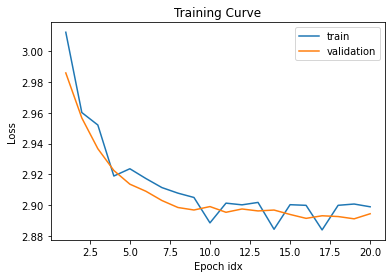

In [46]:
train_losses = []
val_losses = []
tic = time.time()  
for epoch in range(EPOCHS): 
  train_loss = train()
  train_losses.append(train_loss)

  val_loss = evaluate()
  val_losses.append(val_loss)

  print("Epoch %d of %d: Train Loss = %.2f, Val Loss = %.2f" 
        % (epoch+1, EPOCHS, train_loss, val_loss))
  LR = LR / LR_Decay
  optimizer = optim.SGD(model.parameters(), lr=LR)

tac = time.time()
print("Training %d epochs took %d sec. " % (EPOCHS, (tac-tic)))

train_plt, = plt.plot(range(1, EPOCHS+1, 1), train_losses, label="train")
plt.title("Training Curve")
plt.xlabel("Epoch idx")
plt.ylabel("Loss")
val_plt, = plt.plot(range(1, EPOCHS+1, 1), val_losses, label="val")
plt.legend(handles=[train_plt, val_plt], labels=["train", "validation"])

plt.show()

# 4. Test
We should get predictions for test data (without updating parameters) to evaluation the trained model.

In [27]:
# from sklearn.metrics import classification_report
from evaluation import precision_recall_f1

In [ ]:
y_true, y_pred = [], []
for x_batch, y_batch, lengths in batches_generator(BATCH_SIZE, test_tokens, test_tags):

  with torch.no_grad():
    preds, _ = model(torch.LongTensor(x_batch).to(device))            # [bs x T x N]

  preds = np.argmax(preds.cpu().numpy(), axis=2)                 # [bs x T]

  for target_tags, pred_tags, tokens in zip (y_batch, preds, x_batch):
    for target_tag, pred_tag, token in zip (target_tags, pred_tags, tokens):
      if token != token2idx["<PAD>"]:
        y_true.append(target_tag)    
        y_pred.append(pred_tag)

precision_recall_f1(idxs2tags(y_true), idxs2tags(y_pred), print_results=True, short_report=True)
# print("test prediction shape after argmax: ", len(preds))
# print(classification_report(y_true, y_pred))

# TODOs

- [x] Running on the GPU
- [x] Plot training loss curve
- [x] Mini-batch processing
  * Check dimensions
  * Padding to the max length
- [x] Loss function
  * Cross entropy loss
  * Applying mask to the loss
  * Applying class weights to the loss function
- [x] Evaluate on val/test set by Precision, Recall, F1 metrics
- [x] Dynamic learning rate
- [x] Using BiLSTM
- [X] Reqularizations such as dropout
- [ ] Hyperparameter tuning
  * EMBEDDING_DIM
  * HIDDEN_DIM
  * Batch size
  * Number of epochs
  * Optimizer algorithm
  * ...




